# **Vehicle Detection Project**

**The goals / steps of this project are the following:**

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

## Import libraries
* Data handling and visualization
* Image processing
* Video processing

In [2]:
# Data handling and visualization
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
import time

# Image processing
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split # sklearn version 0.19.0
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from textwrap import wrap

# Video processing
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

print(u'\u2713', 'libraries imported')

✓ libraries imported


## Load Images
* Import data (visualize sample car/noncar images)

In [3]:
# Import paths
path_imgIn = 'test_images/'
path_vidIn = 'test_videos/'
    
# Export paths
path_imgOut = 'output_images1/'
path_vidOut = 'output_videos1/'

✓ images imported
Car data size:  8792  samples
Non-car data size:  8968  samples


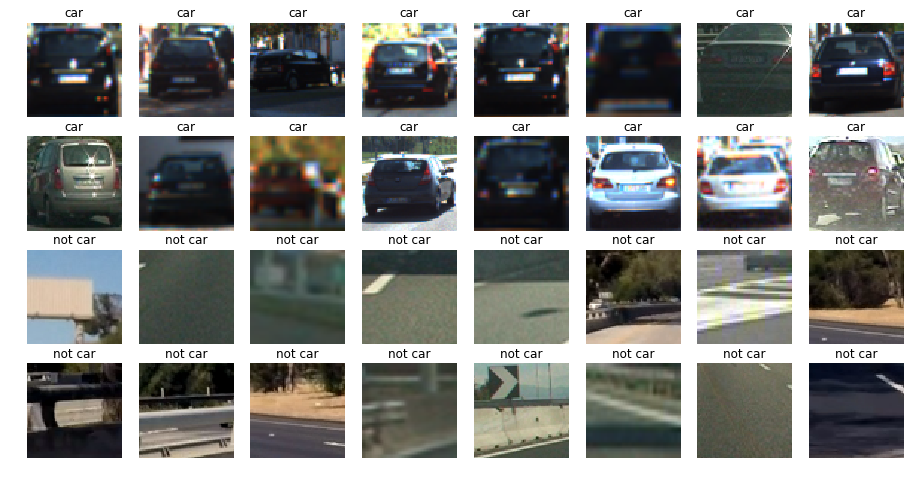

In [4]:
# Import car/noncar data

# Image paths
path_dataCars = '../CarND-Vehicle-Detection/vehicles/'
path_dataNoncars = '../CarND-Vehicle-Detection/non-vehicles/'
# Create lists to store image paths
data_cars = glob.glob(path_dataCars + '**/*.png')
data_noncars = glob.glob(path_dataNoncars + '**/*.png')
n_cars = len(data_cars)
n_noncars = len(data_noncars)

print(u'\u2713', 'images imported')
print('Car data size: ', n_cars, ' samples')
print('Non-car data size: ', n_noncars, ' samples')

# Visualize some of the data
n_row = 4
n_col = 8
f, axs = plt.subplots(n_row, n_col, figsize=(16, 8))
f.subplots_adjust(hspace=.2, wspace=.01)
axs = axs.ravel()
# Car data
for i in np.arange((n_row * n_col) // 2):
    img = cv2.imread(data_cars[np.random.randint(0, n_cars)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
    axs[i].set_title('car')
for i in np.arange((n_row * n_col) // 2, (n_row * n_col)):
    img = cv2.imread(data_noncars[np.random.randint(0, n_noncars)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
    axs[i].set_title('not car')
    
f.savefig(path_imgOut + 'fig1_classData.png')

## Histogram of Oriented Gradients (HOG)
* Get HOG features of image (visualize on sample car/noncar images)
* Determine good HOG parameters for processing images
* Feature extraction to generate Training/Testing datasets

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=False, feature_vector=feature_vec)
        return features
    
print(u'\u2713', 'get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)')

✓ get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)


✓ HOG examples successfully created


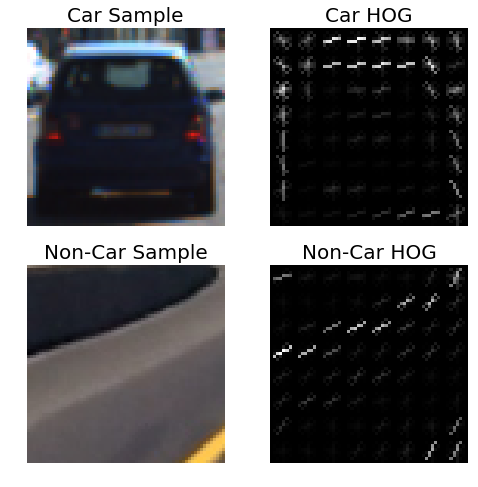

In [6]:
# Perform HOG on sample images of car and noncar
car_img = mpimg.imread(data_cars[np.random.randint(n_cars)])
_, car_hog = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(data_noncars[np.random.randint(n_noncars)])
_, noncar_hog = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize comparison between raw image and HOG
f, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(car_img)
axs[0].set_title('Car Sample', fontsize=20)
axs[1].axis('off')
axs[1].imshow(car_hog, cmap='gray')
axs[1].set_title('Car HOG', fontsize=20)
axs[2].axis('off')
axs[2].imshow(noncar_img)
axs[2].set_title('Non-Car Sample', fontsize=20)
axs[3].axis('off')
axs[3].imshow(noncar_hog, cmap='gray')
axs[3].set_title('Non-Car HOG', fontsize=20)

print(u'\u2713', 'HOG examples successfully created')
f.savefig(path_imgOut + 'fig2.1_HOG.png')

In [7]:
# Define a function tht can convert color channels
def convert_color(img, cspace='RGB'):
    if cspace !='RGB':
        if cspace == 'HSV':
            img_out = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            img_out = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            img_out = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            img_out = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            img_out = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        img_out = np.copy(img)
    return img_out

print(u'\u2713', "convert_color(img, cspace='RGB')")

✓ convert_color(img, cspace='RGB')


✓ colorspace HOGs visualized


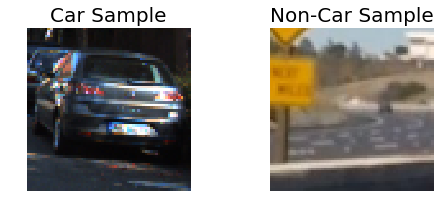

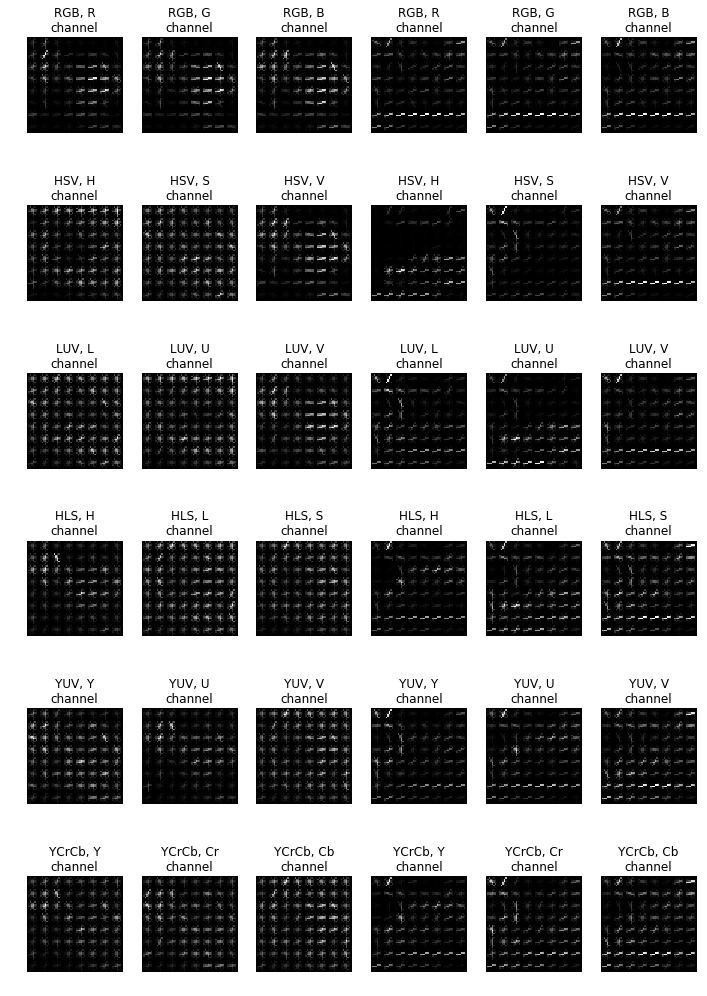

In [8]:
# Start trying out HOG on different colorspaces
color_space = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
n = len(color_space)

# Compare color spaces
i_car = np.random.randint(n_cars)
i_noncar = np.random.randint(n_noncars)
car_img = cv2.imread(data_cars[i_car])
car_img = cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)
noncar_img = cv2.imread(data_noncars[i_noncar])
noncar_img = cv2.cvtColor(noncar_img, cv2.COLOR_BGR2RGB)

f1, axs = plt.subplots(1, 2, figsize=(8, 3))
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(car_img)
axs[0].set_title('Car Sample', fontsize=20)
axs[1].axis('off')
axs[1].imshow(noncar_img)
axs[1].set_title('Non-Car Sample', fontsize=20)

f1.savefig(path_imgOut + 'fig2.2-1_HOGsample.png')

f2, axs = plt.subplots(n, 6, figsize=(12, n*3))
axs = axs.ravel()

for i in np.arange(n):
    car_img = convert_color(car_img, color_space[i])
    _, car_hog0 = get_hog_features(car_img[:,:,0], 9, 8, 8, vis=True, feature_vec=True)
    _, car_hog1 = get_hog_features(car_img[:,:,1], 9, 8, 8, vis=True, feature_vec=True)
    _, car_hog2 = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
    noncar_img = convert_color(noncar_img, color_space[i])
    _, noncar_hog0 = get_hog_features(noncar_img[:,:,0], 9, 8, 8, vis=True, feature_vec=True)
    _, noncar_hog1 = get_hog_features(noncar_img[:,:,1], 9, 8, 8, vis=True, feature_vec=True)
    _, noncar_hog2 = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

    for j in range(6):
        axs[6*i+j].axis('off')
        axs[6*i+j].set_title("\n".join(wrap(color_space[i] + ', '+ re.findall('[A-Z][^A-Z]*', color_space[i])[j%3] + ' channel', 12)))
    axs[6*i+0].imshow(car_hog0, cmap='gray')
    axs[6*i+1].imshow(car_hog1, cmap='gray')
    axs[6*i+2].imshow(car_hog2, cmap='gray')
    axs[6*i+3].imshow(noncar_hog0, cmap='gray')
    axs[6*i+4].imshow(noncar_hog1, cmap='gray')
    axs[6*i+5].imshow(noncar_hog2, cmap='gray')
    
f2.savefig(path_imgOut + 'fig2.2-2_HOGcspace.png')

print(u'\u2713', 'colorspace HOGs visualized')

✓ orientations visualized


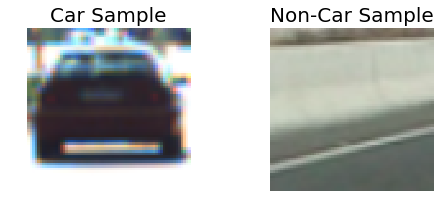

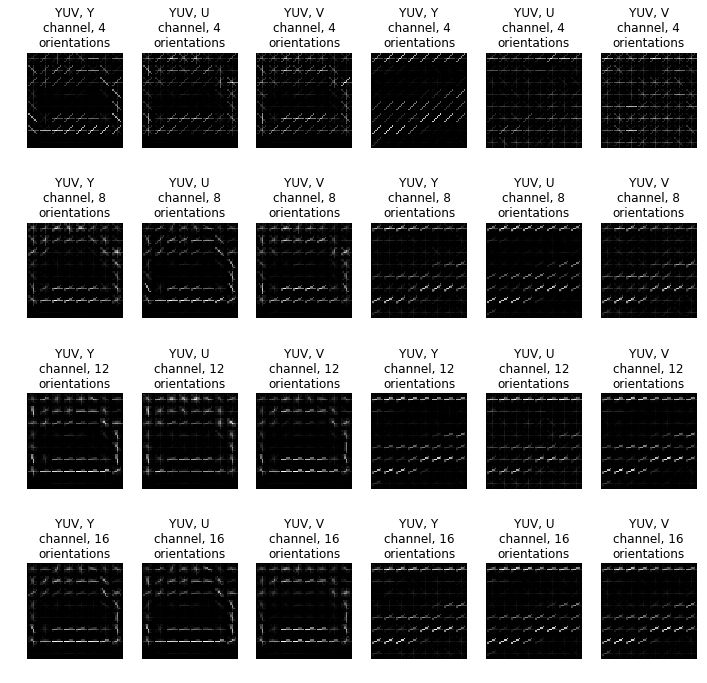

In [9]:
# It seems like YUV performs well, so let's use it for future HOG feature extraction
color_space = 'YUV'
# Next, try different numbers of orientations
orient = [4, 8, 12, 16]
n = len(orient)

# Compare color spaces
i_car = np.random.randint(n_cars)
i_noncar = np.random.randint(n_noncars)
car_img = cv2.imread(data_cars[i_car])
car_img = cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)
noncar_img = cv2.imread(data_noncars[i_noncar])
noncar_img = cv2.cvtColor(noncar_img, cv2.COLOR_BGR2RGB)

f1, axs = plt.subplots(1, 2, figsize=(8, 3))
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(car_img)
axs[0].set_title('Car Sample', fontsize=20)
axs[1].axis('off')
axs[1].imshow(noncar_img)
axs[1].set_title('Non-Car Sample', fontsize=20)

f1.savefig(path_imgOut + 'fig2.3-1_HOGsample.png')

f2, axs = plt.subplots(n, 6, figsize=(12, n*3))
axs = axs.ravel()
for i in np.arange(n):
    car_img = convert_color(car_img, color_space)
    _, car_hog0 = get_hog_features(car_img[:,:,0], orient[i], 8, 8, vis=True, feature_vec=True)
    _, car_hog1 = get_hog_features(car_img[:,:,1], orient[i], 8, 8, vis=True, feature_vec=True)
    _, car_hog2 = get_hog_features(car_img[:,:,2], orient[i], 8, 8, vis=True, feature_vec=True)
    noncar_img = convert_color(noncar_img, color_space)
    _, noncar_hog0 = get_hog_features(noncar_img[:,:,0], orient[i], 8, 8, vis=True, feature_vec=True)
    _, noncar_hog1 = get_hog_features(noncar_img[:,:,1], orient[i], 8, 8, vis=True, feature_vec=True)
    _, noncar_hog2 = get_hog_features(noncar_img[:,:,2], orient[i], 8, 8, vis=True, feature_vec=True)

    for j in range(6):
        axs[6*i+j].axis('off')
        axs[6*i+j].set_title("\n".join(wrap(color_space + ', '+ re.findall('[A-Z][^A-Z]*', color_space)[j%3] + ' channel, ' + str(orient[i]) + ' orientations', 12)))
    axs[6*i+0].imshow(car_hog0, cmap='gray')
    axs[6*i+1].imshow(car_hog1, cmap='gray')
    axs[6*i+2].imshow(car_hog2, cmap='gray')
    axs[6*i+3].imshow(noncar_hog0, cmap='gray')
    axs[6*i+4].imshow(noncar_hog1, cmap='gray')
    axs[6*i+5].imshow(noncar_hog2, cmap='gray')
    
f2.savefig(path_imgOut + 'fig2.3-1_HOGorient.png')

print(u'\u2713', 'orientations visualized')

✓ pix_per_cell visualized


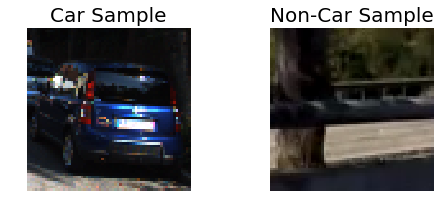

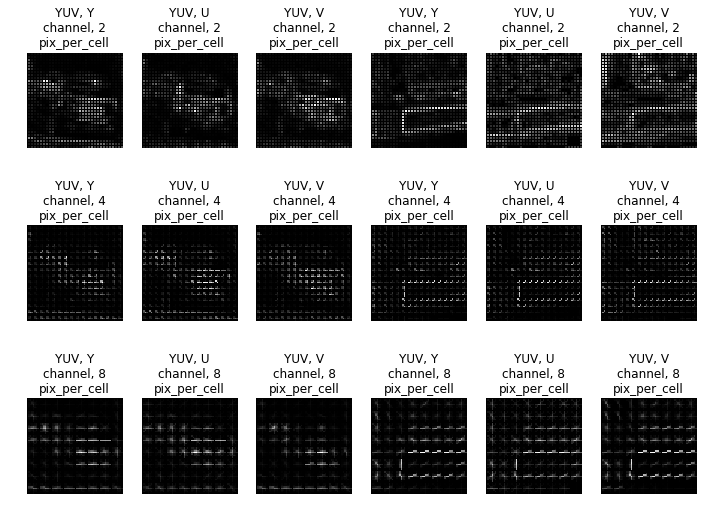

In [10]:
# It seems like 12 has sufficient performance, so set orient=12 for future HOG feature extractions
orient = 12
# Next, let's try the pixels per cell
pix_per_cell = [2, 4, 8]
n = len(pix_per_cell)

# Compare color spaces
i_car = np.random.randint(n_cars)
i_noncar = np.random.randint(n_noncars)
car_img = cv2.imread(data_cars[i_car])
car_img = cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)
noncar_img = cv2.imread(data_noncars[i_noncar])
noncar_img = cv2.cvtColor(noncar_img, cv2.COLOR_BGR2RGB)

f1, axs = plt.subplots(1, 2, figsize=(8, 3))
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(car_img)
axs[0].set_title('Car Sample', fontsize=20)
axs[1].axis('off')
axs[1].imshow(noncar_img)
axs[1].set_title('Non-Car Sample', fontsize=20)

f1.savefig(path_imgOut + 'fig2.4-1_HOGsample.png')

f2, axs = plt.subplots(n, 6, figsize=(12, n*3))
axs = axs.ravel()            
for i in np.arange(n):
    car_img = convert_color(car_img, color_space)
    _, car_hog0 = get_hog_features(car_img[:,:,0], orient, pix_per_cell[i], 8, vis=True, feature_vec=True)
    _, car_hog1 = get_hog_features(car_img[:,:,1], orient, pix_per_cell[i], 8, vis=True, feature_vec=True)
    _, car_hog2 = get_hog_features(car_img[:,:,2], orient, pix_per_cell[i], 8, vis=True, feature_vec=True)
    noncar_img = convert_color(noncar_img, color_space)
    _, noncar_hog0 = get_hog_features(noncar_img[:,:,0], orient, pix_per_cell[i], 8, vis=True, feature_vec=True)
    _, noncar_hog1 = get_hog_features(noncar_img[:,:,1], orient, pix_per_cell[i], 8, vis=True, feature_vec=True)
    _, noncar_hog2 = get_hog_features(noncar_img[:,:,2], orient, pix_per_cell[i], 8, vis=True, feature_vec=True)
    
    for j in range(6):
        axs[6*i+j].axis('off')
        axs[6*i+j].set_title("\n".join(wrap(color_space + ', '+ re.findall('[A-Z][^A-Z]*', color_space)[j%3] + ' channel, ' + str(pix_per_cell[i]) + ' pix_per_cell', 12)))
    axs[6*i+0].imshow(car_hog0, cmap='gray')
    axs[6*i+1].imshow(car_hog1, cmap='gray')
    axs[6*i+2].imshow(car_hog2, cmap='gray')
    axs[6*i+3].imshow(noncar_hog0, cmap='gray')
    axs[6*i+4].imshow(noncar_hog1, cmap='gray')
    axs[6*i+5].imshow(noncar_hog2, cmap='gray')
    
f2.savefig(path_imgOut + 'fig2.4-2_HOGppc.png')
    
print(u'\u2713', 'pix_per_cell visualized')

✓ cell_per_block visualized


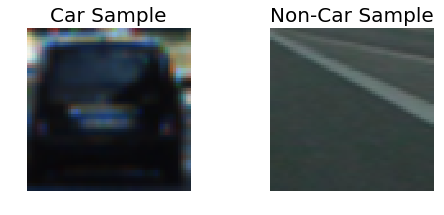

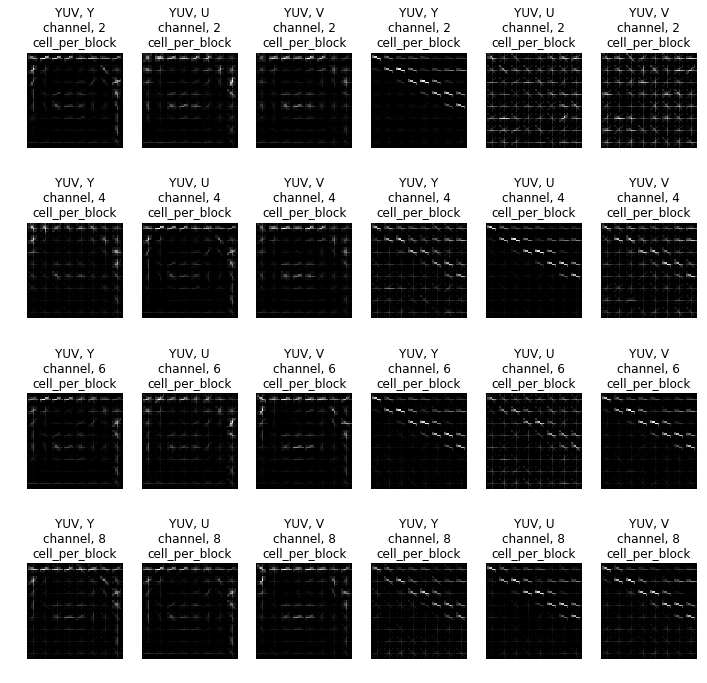

In [11]:
# Clearly 2 pixels per cell performs best, but it may severely limit performance..
# Maybe we can try things out with 8 pixels per cell for the time being
pix_per_cell = 8
# Next up, cells per block
cell_per_block = [2, 4, 6, 8]
n = len(cell_per_block)

# Compare color spaces
i_car = np.random.randint(n_cars)
i_noncar = np.random.randint(n_noncars)
car_img = cv2.imread(data_cars[i_car])
car_img = cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)
noncar_img = cv2.imread(data_noncars[i_noncar])
noncar_img = cv2.cvtColor(noncar_img, cv2.COLOR_BGR2RGB)

f1, axs = plt.subplots(1, 2, figsize=(8, 3))
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(car_img)
axs[0].set_title('Car Sample', fontsize=20)
axs[1].axis('off')
axs[1].imshow(noncar_img)
axs[1].set_title('Non-Car Sample', fontsize=20)

f1.savefig(path_imgOut + 'fig2.5-1_HOGsample.png')
    
f2, axs = plt.subplots(n, 6, figsize=(12, n*3))
axs = axs.ravel()
    
for i in np.arange(len(cell_per_block)):
    car_img = convert_color(car_img, color_space)
    _, car_hog0 = get_hog_features(car_img[:,:,0], orient, pix_per_cell, cell_per_block[i], vis=True, feature_vec=True)
    _, car_hog1 = get_hog_features(car_img[:,:,1], orient, pix_per_cell, cell_per_block[i], vis=True, feature_vec=True)
    _, car_hog2 = get_hog_features(car_img[:,:,2], orient, pix_per_cell, cell_per_block[i], vis=True, feature_vec=True)
    noncar_img = convert_color(noncar_img, color_space)
    _, noncar_hog0 = get_hog_features(noncar_img[:,:,0], orient, pix_per_cell, cell_per_block[i], vis=True, feature_vec=True)
    _, noncar_hog1 = get_hog_features(noncar_img[:,:,1], orient, pix_per_cell, cell_per_block[i], vis=True, feature_vec=True)
    _, noncar_hog2 = get_hog_features(noncar_img[:,:,2], orient, pix_per_cell, cell_per_block[i], vis=True, feature_vec=True)
    
    for j in range(6):
        axs[6*i+j].axis('off')
        axs[6*i+j].set_title("\n".join(wrap(color_space + ', '+ re.findall('[A-Z][^A-Z]*', color_space)[j%3] + ' channel, ' + str(cell_per_block[i]) + ' cell_per_block', 14)))
    axs[6*i+0].imshow(car_hog0, cmap='gray')
    axs[6*i+1].imshow(car_hog1, cmap='gray')
    axs[6*i+2].imshow(car_hog2, cmap='gray')
    axs[6*i+3].imshow(noncar_hog0, cmap='gray')
    axs[6*i+4].imshow(noncar_hog1, cmap='gray')
    axs[6*i+5].imshow(noncar_hog2, cmap='gray')
    
f2.savefig(path_imgOut + 'fig2.5-2_HOGcpb.png')
    
print(u'\u2713', 'cell_per_block visualized')

In [12]:
# Seems like 2 cells per block is sufficient
cell_per_block = 2

### Expanded Feature Extraction

In [13]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=2, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    print('features length:', len(features))
    return features
    
print(u'\u2713', "extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=2, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True)")

✓ extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=2, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True)


In [14]:
# Set extract_feature parameters based on results
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12 # HOG orientations
pix_per_cell = 4  # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32 # Number of histogram bins
hist_range = (0,256)
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

if spatial_feat:
    spatial_txt = str(spatial_size[0]) + ' by ' + str(spatial_size[1]) + ' spatial size'
else:
    spatial_txt = 'No spatial bin features'
if hist_feat:
    hist_txt = str(hist_bins) + ' histogram bins of range ' + str(hist_range[0]) + ' to ' + str(hist_range[1])
else:
    hist_txt = 'No color histogram features'
if hog_feat:
    hog_txt = hog_channel
else:
    hog_txt = '0'

print('HOG features generated with: ', "\n",
      color_space, ' colorspace (', hog_txt, ' channel ),' "\n", 
      orient, ' orientations,', "\n",
      pix_per_cell, 'pixels per cell,', "\n",
      cell_per_block, 'cells per block,', "\n",
      spatial_txt, "\n", hist_txt)

# Conduct feature extraction on sample data
t0 = time.time()
car_features = extract_features(data_cars, color_space=color_space, spatial_size=(32, 32),
                                hist_bins=32, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t1 = time.time()
print(u'\u2713', 'car_features generated', '(' + str(round(t1 - t0, 2)) + ' seconds)')
noncar_features = extract_features(data_noncars, color_space=color_space, spatial_size=(32, 32),
                                hist_bins=32, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(u'\u2713', 'noncar_features generated', '(' + str(round(t2- t1, 2)) + ' seconds)')
t3 = time.time()
print('Total time:', round(t3 - t0, 2), 'seconds to extract HOG features')

# Create matrix of feature vectors and vector of labels
X = np.vstack((car_features, noncar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split into Training/Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Feature vector length:', len(X_train[0]))

HOG features generated with:  
 YUV  colorspace ( ALL  channel ),
 12  orientations, 
 4 pixels per cell, 
 2 cells per block, 
 No spatial bin features 
 No color histogram features
features length: 8792
✓ car_features generated (140.35 seconds)
features length: 8968
✓ noncar_features generated (147.45 seconds)
Total time: 287.8 seconds to extract HOG features
Shape of X_train:  (14208, 32400)
Shape of X_test:  (3552, 32400)
Feature vector length: 32400


### Training a Classifier
* Use a linear SVC to train a classifier model

In [15]:
# Initialize model variables
svc = LinearSVC()

# Train model
t0 = time.time()
svc.fit(X_train, y_train)
t1 = time.time()

# Test model
y_pred = svc.predict(X_test)
t2 = time.time()
acc = accuracy_score(y_pred, y_test)

print(u'\u2713', 'SVC model generated', "\n",
      'Training time:', round(t1 - t0, 2), 'seconds', "\n", 
      'Testing time:', round(t2 - t1, 2), 'seconds', "\n",
      'Prediction accuracy:', round(acc, 5)*100, '%', "\n",
      'Total time elapsed:', round(t2 - t0, 2), 'seconds')


✓ SVC model generated 
 Training time: 898.91 seconds 
 Testing time: 9.2 seconds 
 Prediction accuracy: 98.677 % 
 Total time elapsed: 908.11 seconds


## Sliding Window Search

In [16]:
# Define windows to make classification predictions
def get_windows(img, xy_window=(64, 64), overlap=(0.3, 0), rows=2):
    h, w = img.shape[0], img.shape[1]
    # Determine window search area
    x_step = int((1 - overlap[0]) * xy_window[0]) # horizontal step distance from previous window
    y_step = int((1 - overlap[1]) * xy_window[1]) # vertical step distance from previous window
    x_mid = w // 2 # middle of the image
    x_start = (x_mid - xy_window[0] // 2) % x_step # left-most UL rectangle point
    x_stop = w - x_start - xy_window[0] # right-most rectangle UL point
    y_start = 400 # top-most rectangle UL point
    y_stop = min(y_start + y_step * (rows - 1),
                 h - xy_window[1]) # bottom-most rectangle UL point
    nx_wins = (x_stop - x_start) // x_step + 1
    ny_wins = (y_stop - y_start) // y_step + 1
    rectangles = []
    for j in range(ny_wins):
        y1 = j * y_step + y_start
        y2 = y1 + xy_window[1]
        for i in range(nx_wins):
            x1 = i * x_step + x_start
            x2 = x1 + xy_window[0]
            rectangles.append(((x1, y1), (x2, y2)))
    return rectangles

print(u'\u2713', 'get_rectangles(img, xy_window=(64, 64), overlap=(0.3, 0), rows=2)')

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6, color_inc=True):
    # Make a copy of the image
    imcopy = np.copy(img)
    colorR = color[0]
    colorG = color[1]
    colorB = color[2]
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], (colorR, colorG, colorB), thick)
        colorR = (colorR + 10) % 255
        colorG = (colorG + 30) % 255
        colorB = (colorB + 50) % 255
    # Return the image copy with boxes drawn
    return imcopy

print(u'\u2713', 'draw_boxes(img, bboxes, color=(0, 0, 255), thick=6, color_inc=True)')

✓ get_rectangles(img, xy_window=(64, 64), overlap=(0.3, 0), rows=2)
✓ draw_boxes(img, bboxes, color=(0, 0, 255), thick=6, color_inc=True)


64 x 64 sized windows: 54  boxes
80 x 80 sized windows: 42  boxes
96 x 96 sized windows: 34  boxes
112 x 112 sized windows: 30  boxes
✓ Total number of boxes: 160


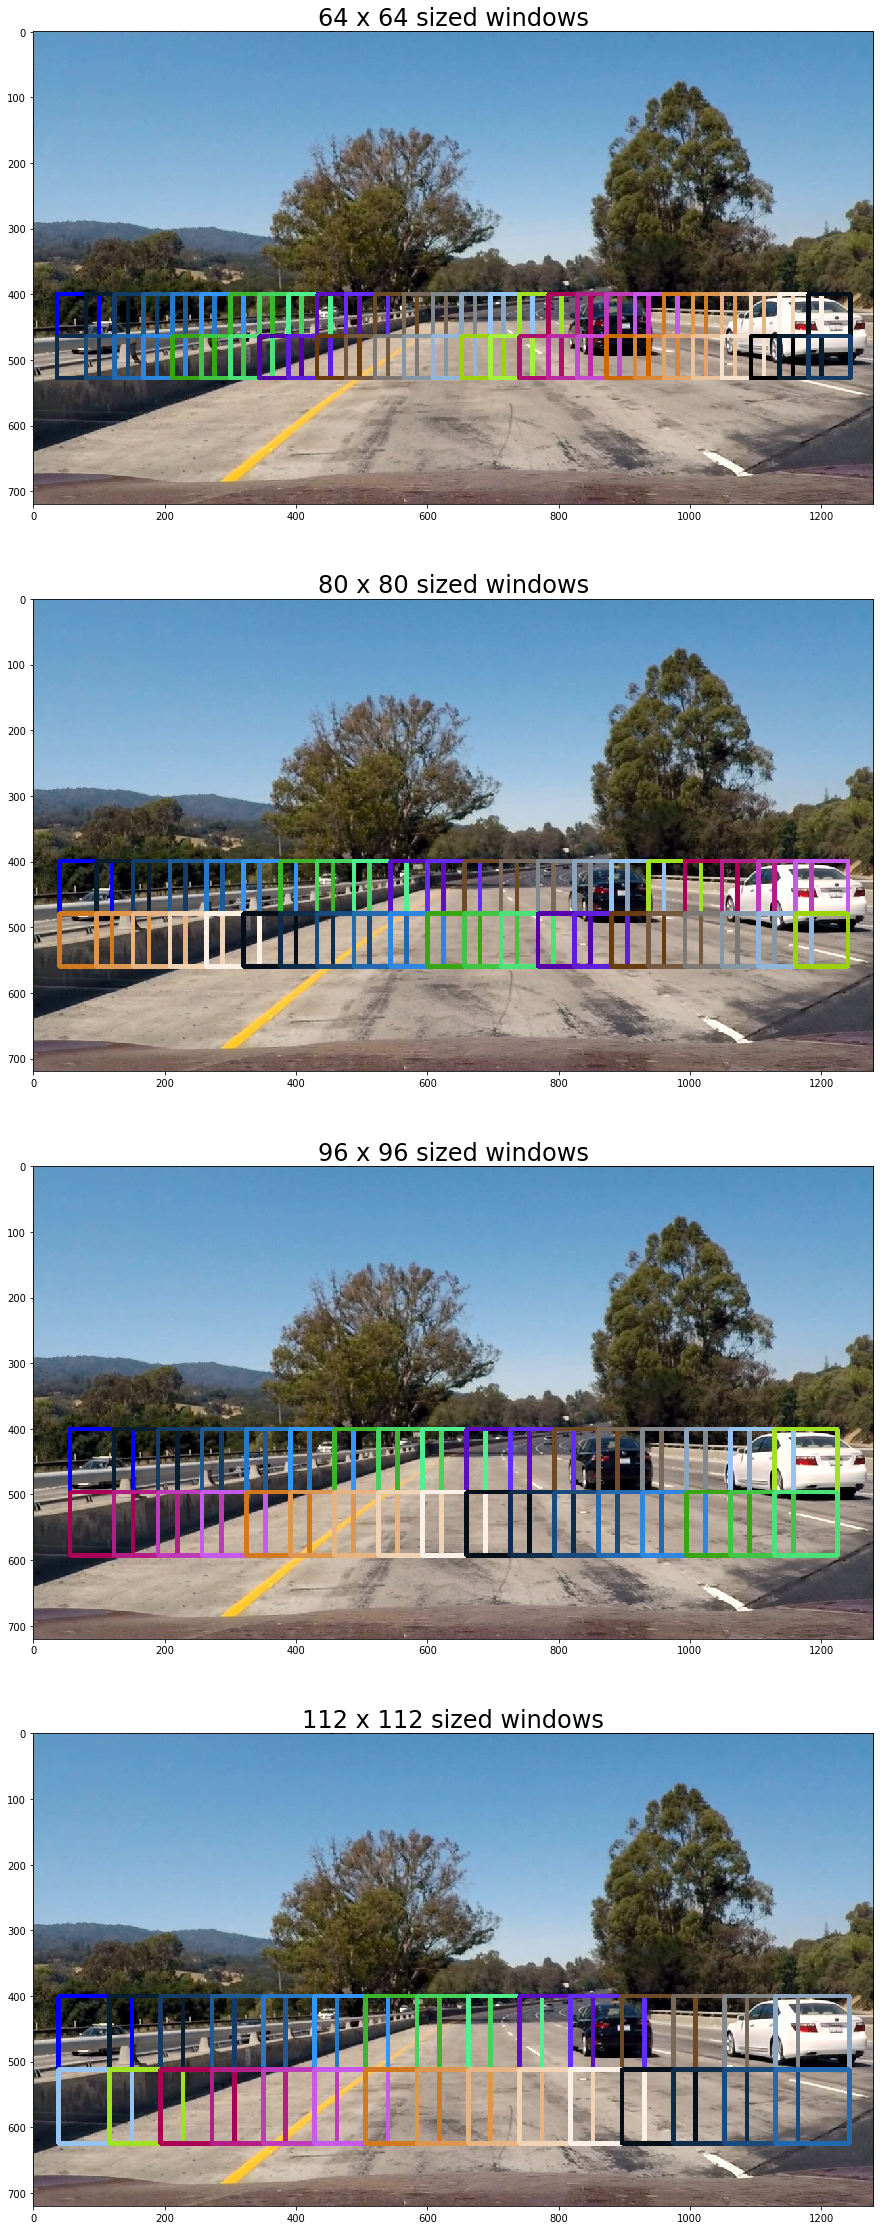

In [17]:
## Visualise windows
path_testImages = 'test_images/'
test_images = glob.glob(path_testImages + '*.jpg')
n_testImages = len(test_images)

test_img = cv2.imread(test_images[0])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

xy_windows = [(64, 64), (80, 80), (96, 96), (112, 112)]
windows_all = []

f, axs = plt.subplots(len(xy_windows), 1, figsize=(50, len(xy_windows) * 10))
for w in range(len(xy_windows)):
    windows = get_windows(test_img, xy_window=xy_windows[w])
    boxes = draw_boxes(test_img, windows)
    axs[w].imshow(boxes)
    axs[w].set_title(str(xy_windows[w][0]) + ' x ' + str(xy_windows[w][1]) + ' sized windows', fontsize=24)
    windows_all.append(windows)
    print(str(xy_windows[w][0]) + ' x ' + str(xy_windows[w][1]) + ' sized windows:', len(windows), ' boxes')

n_boxes = sum([len(windows_all[i]) for i in range(len(windows_all))])
print(u'\u2713', 'Total number of boxes:', n_boxes)

f.savefig(path_imgOut + 'fig3.1_windows.png')

In [ ]:
# Define a function that can detect cars in an image
def find_cars(img, ystart, y_end, boxes, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_rect=False):
    
    img = img.astype(np.float32) / 255
    
    # Decrease image size (reduce parameters)
    img_tosearch = img[y_start:y_end,:,:]
    
    # Perform color conversion
    if cspace != 'RGB':
        if cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    if 0:
        # Rescale image as defined
        if scale != 1:
            h, w = ctrans_tosearch.shape[0], ctrans_tosearch.shape[1]
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (32, 32))

    # Colorspace channels 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]
        
    # Get the boxes that are classified as cars
    car_boxes = []
    for box in boxes:
        # get box region points
        x1, y1 = box[0][0], box[0][1] - y_start
        x2, y2 = box[1][0], box[1][1] - y_start
        # get hog features of region
        hog_feat1 = get_hog_features(cv2.resize(ch1[y1:y2, x1:x2], (64,64)), orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
        if hog_channel == 'ALL':
            hog_feat2 = get_hog_features(cv2.resize(ch2[y1:y2, x1:x2], (64,64)), orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
            hog_feat3 = get_hog_features(cv2.resize(ch3[y1:y2, x1:x2], (64,64)), orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).astype(np.float64)
        else:
            hog_features = hog_feat1
        # make prediction on region
        hog_features = hog_features.reshape(1,-1)
        #print((x1, y1), (x2, y2), 'hog_features shape:', hog_features.shape)
        box_pred = svc.predict(hog_features)
        if box_pred == 1:
            car_boxes.append(box)
        
    return car_boxes

print(u'\u2713', "find_cars(img, ystart, y_end, boxes, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_rect=False)")

In [ ]:
def box_builder(windows):
    boxes = []
    for box in windows:
        boxes += box
    return boxes

print(u'\u2713', 'box_builder(windows)')

In [ ]:
# Testing the box finder
boxes = box_builder(windows_all)
#test_img = mpimg.imread('test_images/test1.jpg')
#file_img = test_images[np.random.randint(n_testImages)]
file_img = test_images[0]
test_img = mpimg.imread(file_img)

cspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12
pix_per_cell = 4
cell_per_block = 2

hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32 # Number of histogram bins
hist_range = (0, 256)
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

scale = 1
y_start = boxes[0][0][1] # 400
y_end = boxes[n_boxes-1][1][1] # 624
X_scaler = StandardScaler()

rectangles = find_cars(test_img, y_start, y_end, boxes, scale, cspace, hog_channel, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_rect=False)
print('# boxes detecting cars:', len(rectangles))

car_img = draw_boxes(test_img, rectangles)
plt.figure(figsize=(20, 10))
plt.imshow(car_img)
plt.title("Detected cars for '" + file_img.split('/')[1] + "'", fontsize=20)
plt.savefig(path_imgOut + 'fig3.2_carsBoxes.png')

## Heatmapping
* Generate heatmap image
* Apply threshold
* Determine bounds for detected cars

In [ ]:
# Generate a heatmap for boxes detecting a vehicle
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap
    
print(u'\u2713', 'add_heat(heatmap, bbox_list)')

In [ ]:
heat_img = np.zeros_like(test_img[:,:,0])
heat_img = add_heat(heat_img, rectangles)
plt.figure(figsize=(20,10))
plt.imshow(heat_img, cmap='hot')
plt.title("Heatmap for '" + file_img.split('/')[1] + "'", fontsize=20)
plt.savefig(path_imgOut + 'fig4.1_heatmap.png')

In [ ]:
ttype = 0

In [ ]:
# Apply a threshold to remove false positives
if ttype:
    def apply_threshold(heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap < threshold] = 0
        # Return thresholded map
        return heatmap

else:
    def apply_threshold(heatmap, threshold):
        threshmap = np.copy(heatmap)
        labels = label(heatmap)
        rects = []
        for box in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == box).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox)+1, np.max(nonzeroy)+1))
            if np.max(threshmap[bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]]) <= threshold:
                labels[0][bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]] = 0
        # Return thresholded map and labels
        labels = label(labels[0])
        return labels

print(u'\u2713', 'apply_threshold(heatmap, threshold)')

In [ ]:
if ttype:
    thresh = 1
    thresh_img = apply_threshold(heat_img, thresh)
    labels = label(thresh_img)
    print('Cars detected:', labels[1])
else:
    thresh = 1
    labels = apply_threshold(heat_img, thresh)
    thresh_img, objs = labels
    print('Cars detected:', objs)
plt.figure(figsize=(20,10))
plt.imshow(thresh_img, cmap='gray')
plt.title("Objects found for " + file_img.split('/')[1] + "' (threshold={})".format(thresh), fontsize=20)
plt.savefig(path_imgOut + 'fig4.2_threshmap.png')

In [ ]:
# Draw labeled boxes onto image
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    img_out = np.copy(img)
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img_out, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img_out, rects

print(u'\u2713', 'draw_labeled_bboxes')

In [ ]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(test_img, labels)
# Display the image
plt.figure(figsize=(20,10))
plt.imshow(draw_img)
plt.title('Cars detected', fontsize=20)
plt.savefig(path_imgOut + 'fig4.3_carsDetected.png')

### Test on images

In [ ]:
def processFrame(img):
    # Set all parameters

    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 12 # HOG orientations
    pix_per_cell = 4 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 32 # Number of histogram bins
    hist_range = (0,256)
    spatial_feat = False # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off

    scale = 1
    y_start = boxes[0][0][1] # 400
    y_end = boxes[n_boxes-1][1][1] # 624
    X_scaler = StandardScaler()

    rectangles = find_cars(img, y_start, y_end, boxes, scale, cspace, hog_channel, svc, X_scaler, orient, 
                           pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_rect=False)
    heat_img = np.zeros_like(img[:,:,0])
    heat_img = add_heat(heat_img, rectangles)

    if ttype:
        thresh = 2
        threshmap = apply_threshold(heat_img, thresh)
        labels = label(threshmap)
    else:
        thresh = max(max(np.unique(heat_img)) - 2, 0)
        labels = apply_threshold(heat_img, thresh)
    draw_img, rect = draw_labeled_bboxes(img, labels)

    return draw_img

In [ ]:
n_images = len(test_images)

f, axs = plt.subplots(n_images, 4, figsize=(16, n_images*3))
f.subplots_adjust(hspace=0.004, wspace=0.002)
axs = axs.ravel()

for i, file in enumerate(test_images):
    # original image
    img = mpimg.imread(file)
    axs[4*i+0].axis('off')
    axs[4*i+0].imshow(img)
    axs[4*i+0].set_title(file.split('/')[1].split('.')[0])
    
    # heatmap image
    rectangles = find_cars(img, y_start, y_end, boxes, scale, cspace, hog_channel, svc, X_scaler, orient, 
                           pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_rect=False)
    heat_img = np.zeros_like(img[:,:,0])
    heat_img = add_heat(heat_img, rectangles)
    axs[4*i+1].axis('off')
    axs[4*i+1].imshow(heat_img, cmap='hot')
    axs[4*i+1].set_title('heatmap')
    
    # thresholded object map
    if ttype:
        threshmap = apply_threshold(heat_img, thresh)
        labels = label(threshmap)
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(labels[0], cmap='gray')
        axs[4*i+2].set_title('threshmap')
    else:
        thresh = max(max(np.unique(heat_img)) - 2, 0)
        labels = apply_threshold(heat_img, thresh)
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(labels[0], cmap='gray')
        axs[4*i+2].set_title('threshmap')
    
    # cars detected
    draw_img, rect = draw_labeled_bboxes(img, labels)
    axs[4*i+3].axis('off')
    axs[4*i+3].imshow(draw_img)
    axs[4*i+3].set_title(str(labels[1]) + ' cars detected')
    
plt.savefig(path_imgOut + 'fig5_imagesCarsDetected.png')

## Video Implementation

In [ ]:
test_out_file = path_vidOut + 'test_video_out.mp4'
clip_test = VideoFileClip(path_vidIn + 'test_video.mp4')
clip_test_out = clip_test.fl_image(processFrame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

In [ ]:
test_out_file = path_vidOut + 'project_video_out.mp4'
clip_test = VideoFileClip(path_vidIn + 'project_video.mp4')
clip_test_out = clip_test.fl_image(processFrame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

## Discussion